In [98]:
%load_ext autoreload
%autoreload 2

In [99]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import geopandas as gpd
import os
import shapely
from shapely.geometry import LineString, Point
from shapely.ops import cascaded_union
import numpy as np
import time
from sklearn.preprocessing import normalize
from numpy import linalg
from util import *
import hickle as hkl 
import pdb

In [100]:
def group_and_map(filename):
    t = pd.read_csv(filename)
    t['count'] = 1
    count = t.groupby(['pu','do'])['count'].count()
    count = pd.DataFrame(count)
    count.columns = ['Count']
    count.reset_index(inplace = True)
    del t
    keep = count.groupby(['pu'])['Count'].sum()
    keep = list(keep[keep/keep.sum() > 1e-4].index)
    count = count[count.pu.apply(lambda x: x in keep) * count.do.apply(lambda x: x in keep)]
    count.reset_index(inplace = True, drop = True)
    unique = count.pu.unique()
    statemap = dict(zip(unique, range(len(unique))))
    return count, statemap

def build_matrix(count, statemap):
    A = np.zeros((len(statemap),len(statemap)))
    for i in range(count.shape[0]):
        try:
            A[int(statemap[count.pu[i]]), int(statemap[count.do[i]])] = count.Count[i]
        except Exception as e:
            raise ValueError(e)
    A = normalize(A, norm = 'l1',axis = 1)
    assert all(np.isclose(linalg.norm(A, ord = 1,axis = 1), np.ones(A.shape[0])))
    return A

def inspect(A):
    plt.hist(A.sum(axis = 0), bins = 15,range = (0,15))
    plt.show()
    plt.hist(A.sum(axis = 1), bins = 15,range = (0,15))
    plt.show()

def get_center(grid):
    grid.geometry = grid.geometry.apply(lambda x: x.centroid)
    return grid

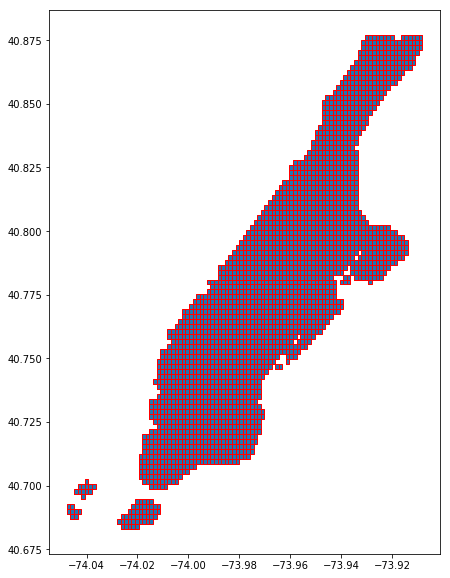

In [101]:
man = get_zones()
grid = get_joint_grid(man, 100, True)
grid = get_center(grid)

In [105]:
count,statemap = group_and_map('./100/100_Grid_AggregatedTrip.csv')

C:\ProgramData\Anaconda4\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


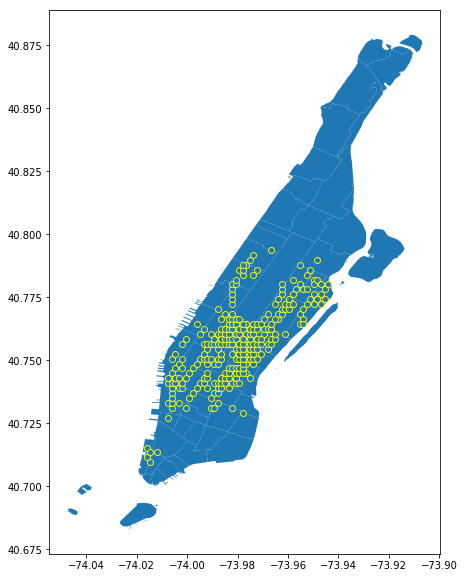

In [109]:
zone = gpd.read_file(r'taxi_zones\taxi_zones.shp')
zone = zone.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
man= zone[zone.borough == 'Manhattan']
fig, ax = plt.subplots(figsize = (10,10))
man.plot(ax=ax)
grid.loc[list(set(count[count.Count > 200].pu)),].plot(**{'edgecolor': 'yellow', 'alpha':0.9}, ax = ax)

In [111]:
A = build_matrix(count,statemap)

In [113]:
# print(A.shape)
# print(len(count))
# hkl.dump(A, '100_matrix.hkl' )

### Decomposition

In [114]:
import numpy as np
from sklearn.decomposition import nmf
#import nmf_new
from sklearn.preprocessing import normalize
from numpy import linalg, random
from numpy.linalg import norm
from util import *
from nmf_adaptive import *

In [115]:
LAMBDA = 1e-10
EPS = 1e-14
GAMMA1 = 1.1
GAMMA2 = 1.2
LR = 100
d = A.shape[0]
r = 2
s0 = 1
U,V,mu,E = non_negative_factorization(A,s0,lr = LR, max_iter = 7, lambda_ = LAMBDA, eps = EPS, gamma1 = GAMMA1, gamma2 = GAMMA2)

In [116]:
U.shape

(1093, 6)

In [117]:
#hkl.dump(U, '100_matrix_U.hkl' )

### Clustering

In [77]:
U,V = hkl.load(r'C:\Research\NMF\State-Aggregation\100\Output_r=1')
statemap = hkl.load(r'C:\Research\NMF\State-Aggregation\100\100_Statemap.hkl')
grid = gpd.GeoDataFrame(pd.read_csv(r'C:\Research\NMF\State-Aggregation\100\100_Grid.csv'))

In [119]:
from sklearn.cluster import KMeans
pred = KMeans(n_clusters=10).fit_predict(U)

In [120]:
inv_statemap = {v:k for k,v in statemap.items()}

In [121]:
mapped_result = []
for group in range(10):
    mapped_result.append([inv_statemap[mem] for mem in list(np.where(pred == group)[0])])

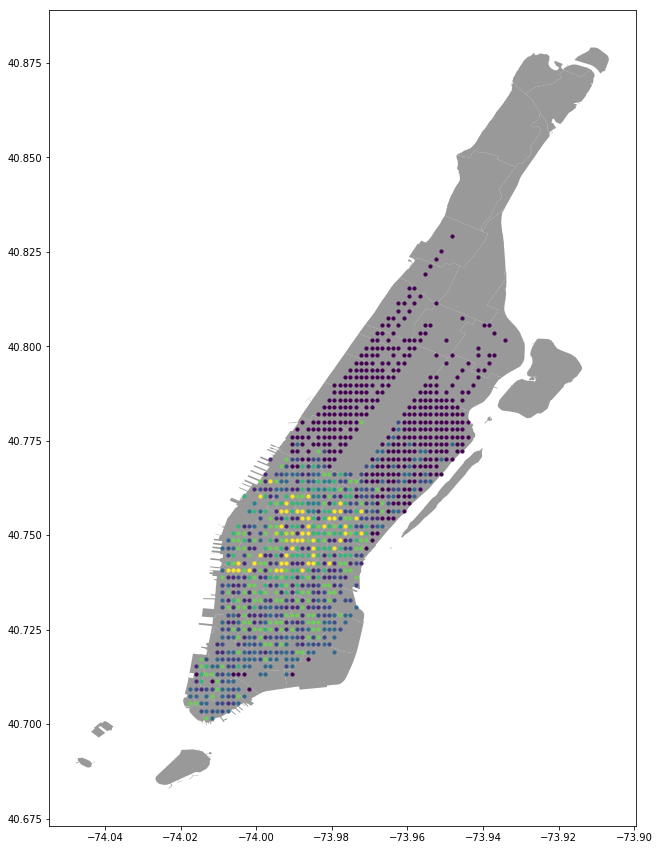

In [144]:
zone = gpd.read_file(r'taxi_zones\taxi_zones.shp')
zone = zone.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
man= zone[zone.borough == 'Manhattan']
fig, ax = plt.subplots(figsize = (15,15))
man.plot(ax=ax, color = 'grey', alpha = 0.8)
ColorsA=plt.cm.viridis(np.linspace(0, 1,len(mapped_result)),alpha=10)
for i,group in enumerate(mapped_result):
    grid.iloc[group,].plot(**{'color': ColorsA[i], 'markersize':10}, ax = ax)
plt.savefig('test.png')